In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

from cbsim.net import Net
from cbsim.request import Request
from cbsim.stochastic import Stochastic
from cbsim.experiment import read_exper_data

In [2]:
net = Net()
net.load_from_file(fnodes='nodes.txt', flinks='links.txt')

# traffic flow studies from May 2021
days = 5
fdata = {
    0: [[68, 70, 92, 84, 119], [70, 82, 80, 67, 77]],           # Sławkowska
    2: [[52, 38, 35, 40, 54], [45, 38, 48, 40, 40]],            # Szczepańska
    4: [[67, 64, 113, 129, 131], [149, 157, 142, 142, 171]],    # Św. Anny
    5: [[30, 27, 31, 31, 43], [66, 64, 60, 55, 93]],            # Franciszkańska
    6: [[22, 38, 36, 35, 52], [149, 134, 120, 184, 102]],       # Poselska
    10: [[153, 143, 172, 176, 214], [130, 122, 119, 152, 142]], # Sienna
    12: [[43, 45, 49, 57, 60], [57, 48, 57, 59, 69]]            # Szpitalna
}

flows = {}
for f in fdata:
    d = fdata[f]
    flows[f] = int(np.array([d[0][i] + d[1][i] for i in range(days)]).mean())
_total = sum(flows.values()) # total number of requests to generate

loadpoints = {15: 'A', 28: 'B', 24: 'C', 19: 'D', 8: 'E', 20: 'F'}
# probs = { 'R': 0.2, 'H': 0.05, 'S': 0.2, 'P': 0.15, 'W': 0.05 }
probs = { 'R': 1, 'H': 1, 'S': 1, 'P': 1, 'W': 1 }

clients = [nd for nd in net.nodes if nd.type != 'N' and nd.type != 'L']
entries = sorted(flows.keys())
outlets = [
    0,  # Sławkowska
    1,  # Św. Tomasza
    3,  # Szewska
    5,  # Franciszkańska
    7,  # Kanonicza
    8,  # Grodzka
    9,  # Dominikańska
    10, # Sienna
    11, # Mikołajska
    12  # Szpitalna
]
zones = sorted([r.code for r in net.regions])

def simulate(weight=0.15, capacity=0.15):

    # 1) generate requests
    generated = 0
    reqs = []
    while generated < _total:
        dst = np.random.choice(clients)
        if np.random.random() < probs[dst.type]:
            req = Request(0, None, dst)
            generated += 1
            reqs.append(req)
    # 2) generate demand using the proposed aproach
    reqs = net.gen_demand(flows=flows,
                        probs=probs,
                        requests=reqs,
                        s_weight=Stochastic(law=1, location=weight, scale=0.3*weight),
                        traditional=False)
    # 3) calculate distances savings
    dds = net.simulate(requests=reqs, outlets=outlets, loadpoints=None, capacity=capacity)
    bds = net.simulate(requests=reqs, outlets=outlets, loadpoints=loadpoints.keys(), capacity=capacity)
    # print(len(dds[0]), len(dds[1]), sum(dds[0]), sum(dds[1]))
    # print(len(bds[0]), len(bds[1]), sum(bds[0]), sum(bds[1]), sum(bds[0]) + sum(bds[1]))
    #print(sum(dds[0]) - sum(bds[0]) - sum(bds[1]))
    return dds[0], bds[0], bds[1]


<H1>Run simulations

In [4]:
capacities = [0.1, 0.15, 0.2, 0.25, 0.3]
sample = 10
ws = [round(0.01 + i * 0.01, 2) for i in range(20)] + \
     [round(0.2 + i * 0.05, 2) for i in range(17)]

for capacity in capacities:
    simfile = open('weight-experiment-c={}.txt'.format(capacity), 'w')
    for w in ws:
        for _ in range(sample):
            res = simulate(w, capacity)
            simfile.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(w,
                len(res[0]), sum(res[0]),
                len(res[1]), sum(res[1]),
                len(res[2]), sum(res[2])))
            print(capacity, w, sum(res[0]) - sum(res[1]) - sum(res[2]))
    simfile.close()

0.1 0.01 470.63299999999685
0.1 0.01 470.56599999999685
0.1 0.01 473.1299999999969
0.1 0.01 482.1929999999961
0.1 0.01 468.55699999999547
0.1 0.01 468.5659999999982
0.1 0.01 484.0819999999951
0.1 0.01 483.9029999999975
0.1 0.01 484.1899999999971
0.1 0.01 480.9869999999962
0.1 0.02 472.99999999999727
0.1 0.02 492.98999999999637
0.1 0.02 477.3629999999953
0.1 0.02 481.67799999999465
0.1 0.02 471.49999999999795
0.1 0.02 482.6289999999958
0.1 0.02 477.0169999999978
0.1 0.02 481.867999999997
0.1 0.02 468.5769999999966
0.1 0.02 482.70799999999895
0.1 0.03 474.98399999999674
0.1 0.03 486.96499999999673
0.1 0.03 467.02999999999724
0.1 0.03 474.45699999999533
0.1 0.03 484.02299999999786
0.1 0.03 478.40699999999606
0.1 0.03 470.356999999997
0.1 0.03 498.10099999999625
0.1 0.03 461.2329999999977
0.1 0.03 471.5329999999967
0.1 0.04 472.199999999998
0.1 0.04 474.4039999999957
0.1 0.04 482.53599999999824
0.1 0.04 451.2719999999964
0.1 0.04 470.102999999996
0.1 0.04 482.48399999999765
0.1 0.04 478.83

In [271]:
sims = []
simfile = open('sim-mean-0.15-50.txt', 'r')
for line in simfile.readlines():
    sims.append(round(float(line), 3))
simfile.close()

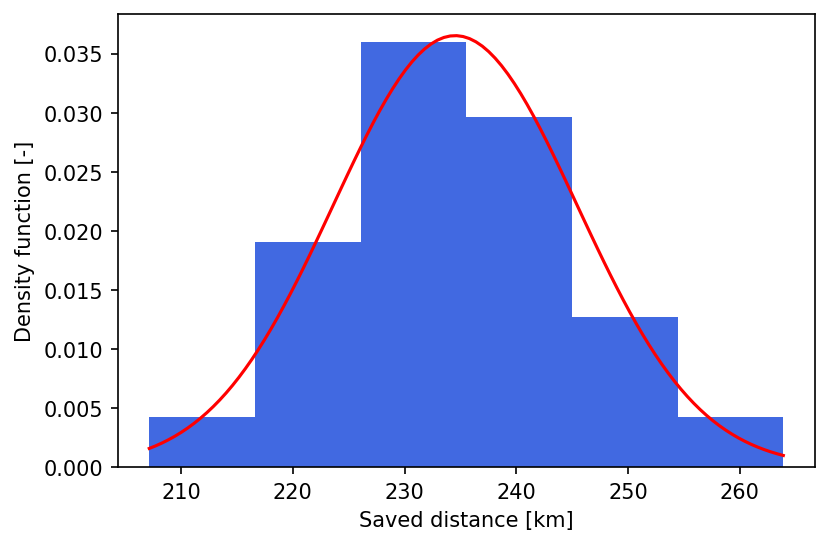

In [270]:
sims = np.array(sims)
xs = np.linspace(sims.min(), sims.max(), 100)
plt.figure(dpi=150)
plt.plot(xs, stats.norm.pdf(xs, *stats.norm.fit(sims)), color='red')
plt.hist(sims, density=True, color='royalblue', bins=6)
plt.xlabel('Saved distance [km]')
plt.ylabel('Density function [-]')
plt.show()

In [72]:
sims = np.array(sims)
stats.norm.ppf(0.95)**2 * sims.var() / (0.05 * sims.mean())**2

2.3483953741273402

In [90]:
sims.mean(), sims.std()

(234.53040000000135, 10.925152300997802)

<H1>Read simulations data

In [7]:
wsmin = read_exper_data(['weight-experiment-min.txt',
                         'weight-experiment-min-small.txt',
                         'weight-experiment-min-big.txt'])
wsmid = read_exper_data(['weight-experiment.txt',
                         'weight-experiment-small.txt',
                         'weight-experiment-small-2.txt',
                         'weight-experiment-big.txt',
                         'weight-experiment-0.65.txt',
                         'weight-experiment-0.70.txt'])
wsmax = read_exper_data(['weight-experiment-max-small.txt',
                         'weight-experiment-max.txt',
                         'weight-experiment-max-big.txt'])

wsmin1 = read_exper_data(['weight-experiment-min-p=1.0.txt',
                          'weight-experiment-min-p=1.0-small.txt',
                          'weight-experiment-min-p=1.0-big.txt'])
wsmid1 = read_exper_data(['weight-experiment-p=1.0.txt',
                          'weight-experiment-p=1.0-small.txt',
                          'weight-experiment-p=1.0-big.txt',
                          'weight-experiment-0.65-p=1.0.txt',
                          'weight-experiment-0.70-p=1.0.txt'])
wsmax1 = read_exper_data(['weight-experiment-max-p=1.0.txt',
                          'weight-experiment-max-p=1.0-small.txt',
                          'weight-experiment-max-p=1.0-big.txt'])

vsmin = read_exper_data(['weight-experiment-min.txt',
                         'weight-experiment-min-small.txt'],
                         False)
vsmid = read_exper_data(['weight-experiment.txt',
                         'weight-experiment-small.txt',
                         'weight-experiment-small-2.txt'],
                         False)
vsmax = read_exper_data(['weight-experiment-max-small.txt',
                         'weight-experiment-max.txt'],
                         False)

ws = [w for w in wsmid.keys() if w <= 0.5]

In [9]:
wsmid1.keys()

dict_keys([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

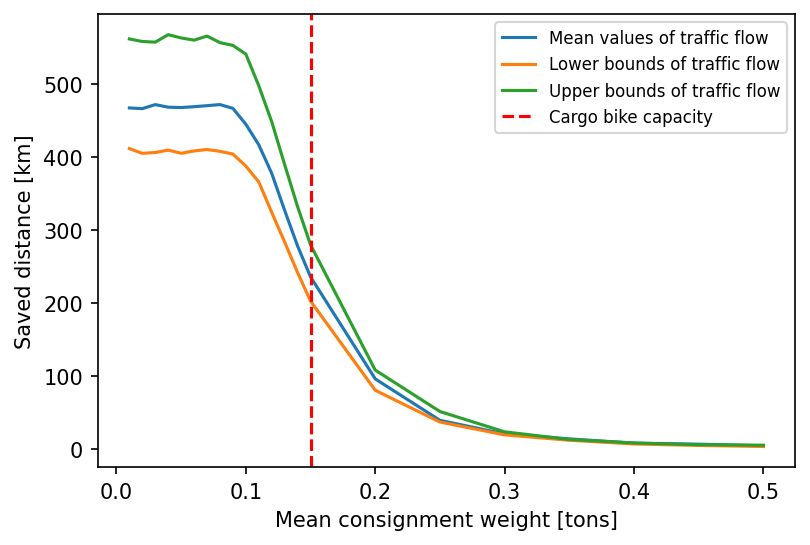

In [4]:
plt.figure(dpi=150)
plt.plot(ws, [wsmid[w] for w in ws], label='Mean values of traffic flow')
plt.plot(ws, [wsmin[w] for w in ws], label='Lower bounds of traffic flow')
plt.plot(ws, [wsmax[w] for w in ws], label='Upper bounds of traffic flow')
plt.axvline(0.15, linestyle='--', color='red', label='Cargo bike capacity')
plt.xlabel('Mean consignment weight [tons]')
plt.ylabel('Saved distance [km]')
plt.legend(fontsize=8)
plt.show()

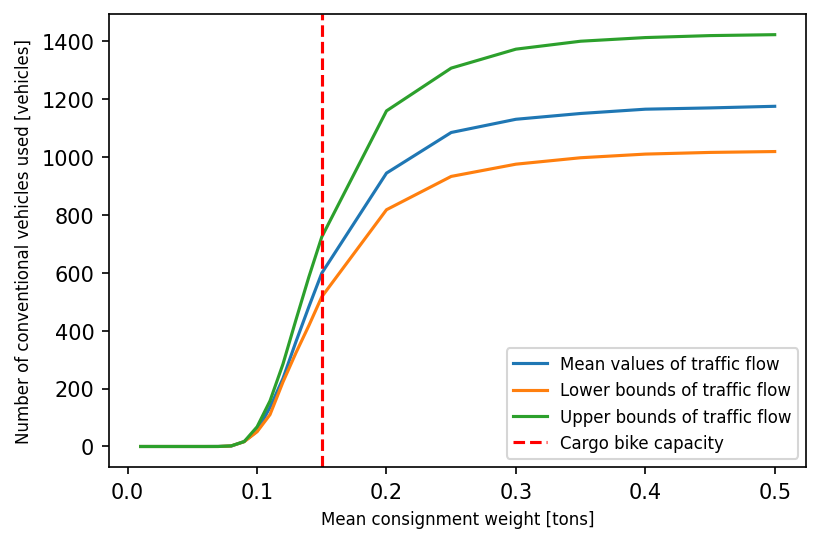

In [10]:
plt.figure(dpi=150)
plt.plot(ws, [vsmid[w] for w in ws], label='Mean values of traffic flow')
plt.plot(ws, [vsmin[w] for w in ws], label='Lower bounds of traffic flow')
plt.plot(ws, [vsmax[w] for w in ws], label='Upper bounds of traffic flow')
plt.axvline(0.15, linestyle='--', color='red', label='Cargo bike capacity')
plt.xlabel('Mean consignment weight [tons]', fontsize=8)
plt.ylabel('Number of conventional vehicles used [vehicles]', fontsize=8)
plt.legend(fontsize=8)
plt.show()

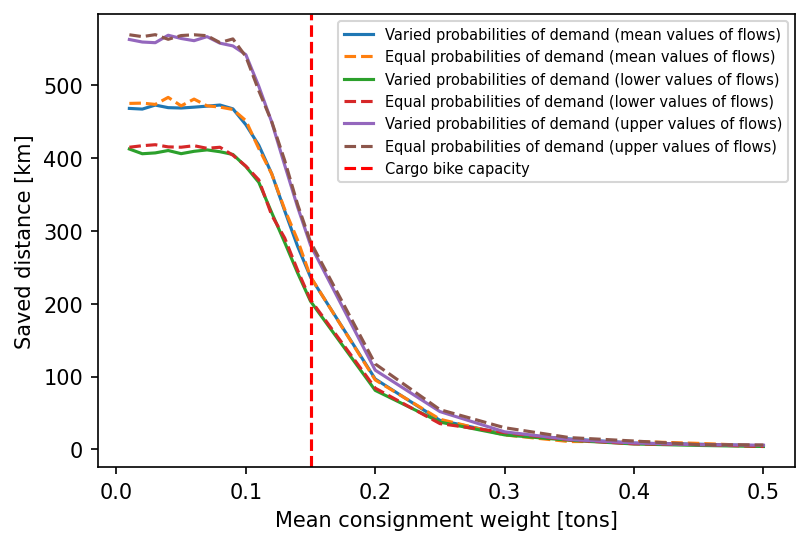

In [14]:
plt.figure(dpi=150)

plt.plot(ws, [wsmid[w] for w in ws], label='Varied probabilities of demand (mean values of flows)')
plt.plot(ws, [wsmid1[w] for w in ws], label='Equal probabilities of demand (mean values of flows)', linestyle='--')

plt.plot(ws, [wsmin[w] for w in ws], label='Varied probabilities of demand (lower values of flows)')
plt.plot(ws, [wsmin1[w] for w in ws], label='Equal probabilities of demand (lower values of flows)', linestyle='--')

plt.plot(ws, [wsmax[w] for w in ws], label='Varied probabilities of demand (upper values of flows)')
plt.plot(ws, [wsmax1[w] for w in ws], label='Equal probabilities of demand (upper values of flows)', linestyle='--')

plt.axvline(0.15, linestyle='--', color='red', label='Cargo bike capacity')

plt.xlabel('Mean consignment weight [tons]')
plt.ylabel('Saved distance [km]')
plt.legend(fontsize=7)
plt.show()

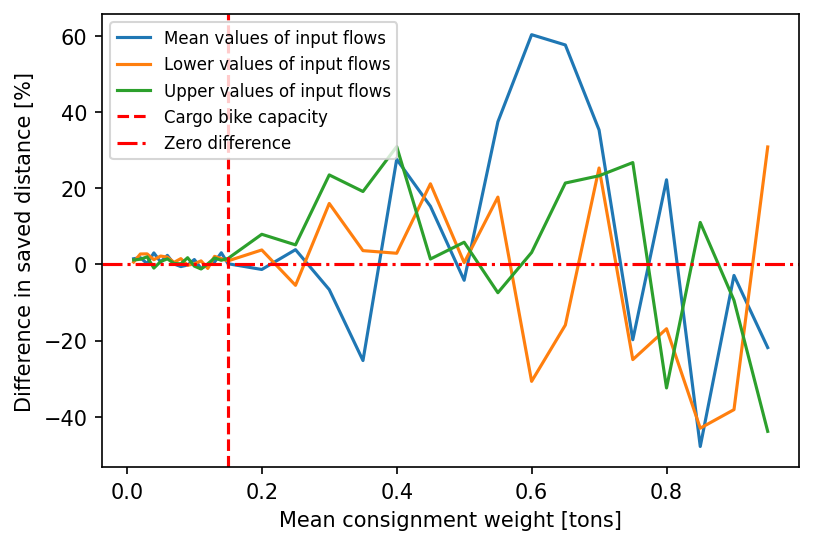

In [12]:
plt.figure(dpi=150)

plt.plot(wsmid.keys(), 
         [100 * (wsmid1[w] - wsmid[w]) / wsmid[w] for w in wsmid.keys()],
         label='Mean values of input flows')
plt.plot(wsmin.keys(), 
         [100 * (wsmin1[w] - wsmin[w]) / wsmin[w] for w in wsmin.keys()],
         label='Lower values of input flows')
plt.plot(wsmax.keys(), 
         [100 * (wsmax1[w] - wsmax[w]) / wsmax[w] for w in wsmax.keys()],
         label='Upper values of input flows')

plt.axvline(0.15, linestyle='--', color='red', label='Cargo bike capacity')
plt.axhline(0, linestyle='-.', color='red', label='Zero difference')

plt.xlabel('Mean consignment weight [tons]')
plt.ylabel('Difference in saved distance [%]')
plt.legend(fontsize=8)
plt.show()

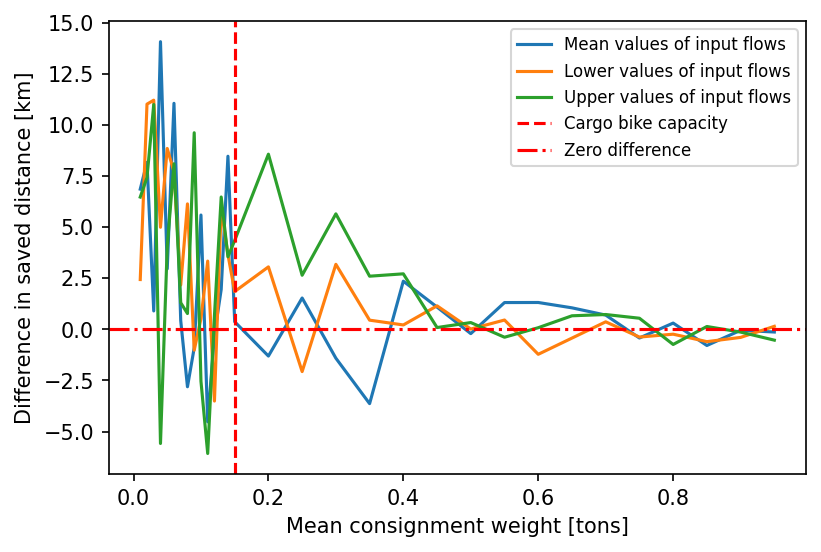

In [13]:
plt.figure(dpi=150)

plt.plot(wsmid.keys(), 
         [(wsmid1[w] - wsmid[w]) for w in wsmid.keys()],
         label='Mean values of input flows')
plt.plot(wsmin.keys(), 
         [(wsmin1[w] - wsmin[w]) for w in wsmin.keys()],
         label='Lower values of input flows')
plt.plot(wsmax.keys(), 
         [(wsmax1[w] - wsmax[w]) for w in wsmax.keys()],
         label='Upper values of input flows')

plt.axvline(0.15, linestyle='--', color='red', label='Cargo bike capacity')
plt.axhline(0, linestyle='-.', color='red', label='Zero difference')

plt.xlabel('Mean consignment weight [tons]')
plt.ylabel('Difference in saved distance [km]')
plt.legend(fontsize=8)
plt.show()

In [5]:
wcs = {}
for c in capacities:
    wcs[c] = read_exper_data(['weight-experiment-c={}.txt'.format(c)])

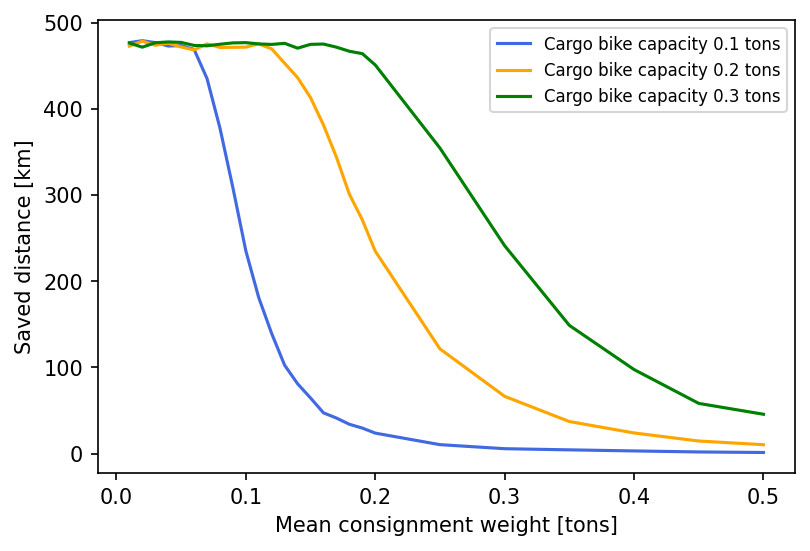

In [27]:
ws = [round(0.01 + i * 0.01, 2) for i in range(20)] + \
     [round(0.2 + i * 0.05, 2) for i in range(7)]

colors = ['royalblue', 'orange', 'green', 'red', 'purple']

plt.figure(dpi=150)
i = 0
for c in [0.1, 0.2, 0.3]: #capacities:
    plt.plot(ws, [wcs[c][w] for w in ws], label='Cargo bike capacity {} tons'.format(c), color=colors[i])
    # plt.axvline(c, linestyle='--', color=colors[i])
    i += 1

# plt.plot(capacities, [wcs[c][c] for c in capacities], linestyle='-.')
# plt.axhline(0.5 * (min(wcs[c].values()) + max(wcs[c].values())), linestyle='-.')

plt.xlabel('Mean consignment weight [tons]')
plt.ylabel('Saved distance [km]')
plt.legend(fontsize=8)
plt.show()